# 1. Imports 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# constants
path = 'C:/Users/monte/Documents/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
O_df = O_df.drop('Unnamed: 0',axis=1)
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
B_df = B_df.drop('Unnamed: 0',axis=1)

# 2. Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']


x = B_df.drop(target,axis = 1)
y = B_df[target]

yScaler = StandardScaler()
yScaler = yScaler.fit(y)

x_train, x_val, y_train, y_val = train_test_split(x, yScaler.transform(y), train_size=0.8, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=42)

In [3]:
B_df.head()

,4440.000,4440.100,4440.200,4440.300,4440.400,4440.500,4440.600,4440.700,4440.800,4440.900,...,4509.400,4509.500,4509.600,4509.700,4509.800,4509.900,4510.000,temperature,g,v
0,0.9995,0.9997,0.9998,0.9998,0.9998,0.9996,0.9991,0.9987,0.9984,0.9981,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,102.0
1,0.9995,0.9997,0.9998,0.9998,0.9997,0.9994,0.9990,0.9986,0.9983,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,105.0
2,0.9995,0.9997,0.9998,0.9998,0.9997,0.9992,0.9988,0.9985,0.9982,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,108.0
3,0.9995,0.9997,0.9998,0.9997,0.9995,0.9991,0.9987,0.9984,0.9982,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,111.0
4,0.9995,0.9997,0.9998,0.9997,0.9993,0.9989,0.9986,0.9984,0.9982,0.9980,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,15000.0,1.75,114.0


# 3. NN Training

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

normalize = layers.Normalization()

normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [5]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 701, 1)]          0         
                                                                 
 normalization (Normalizatio  (None, 701, 701)         1403      
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 701, 32)           67328     
                                                                 
 conv1d_1 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 234, 32)          0         
 )                                                           

In [6]:
model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=10)

Epoch 1/10
459/459 [==============================] - 23s 40ms/step - loss: 0.2652 - MAE: 0.3650 - val_loss: 0.1102 - val_MAE: 0.2382
Epoch 2/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0867 - MAE: 0.2056 - val_loss: 0.0644 - val_MAE: 0.1890
Epoch 3/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0423 - MAE: 0.1470 - val_loss: 0.0249 - val_MAE: 0.1153
Epoch 4/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0248 - MAE: 0.1138 - val_loss: 0.0208 - val_MAE: 0.1035
Epoch 5/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0167 - MAE: 0.0944 - val_loss: 0.0183 - val_MAE: 0.1011
Epoch 6/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0130 - MAE: 0.0848 - val_loss: 0.0137 - val_MAE: 0.0906
Epoch 7/10
459/459 [==============================] - 16s 35ms/step - loss: 0.0072 - MAE: 0.0630 - val_loss: 0.0103 - val_MAE: 0.0747
Epoch 8/10
459/459 [==============================] - 16s 35ms

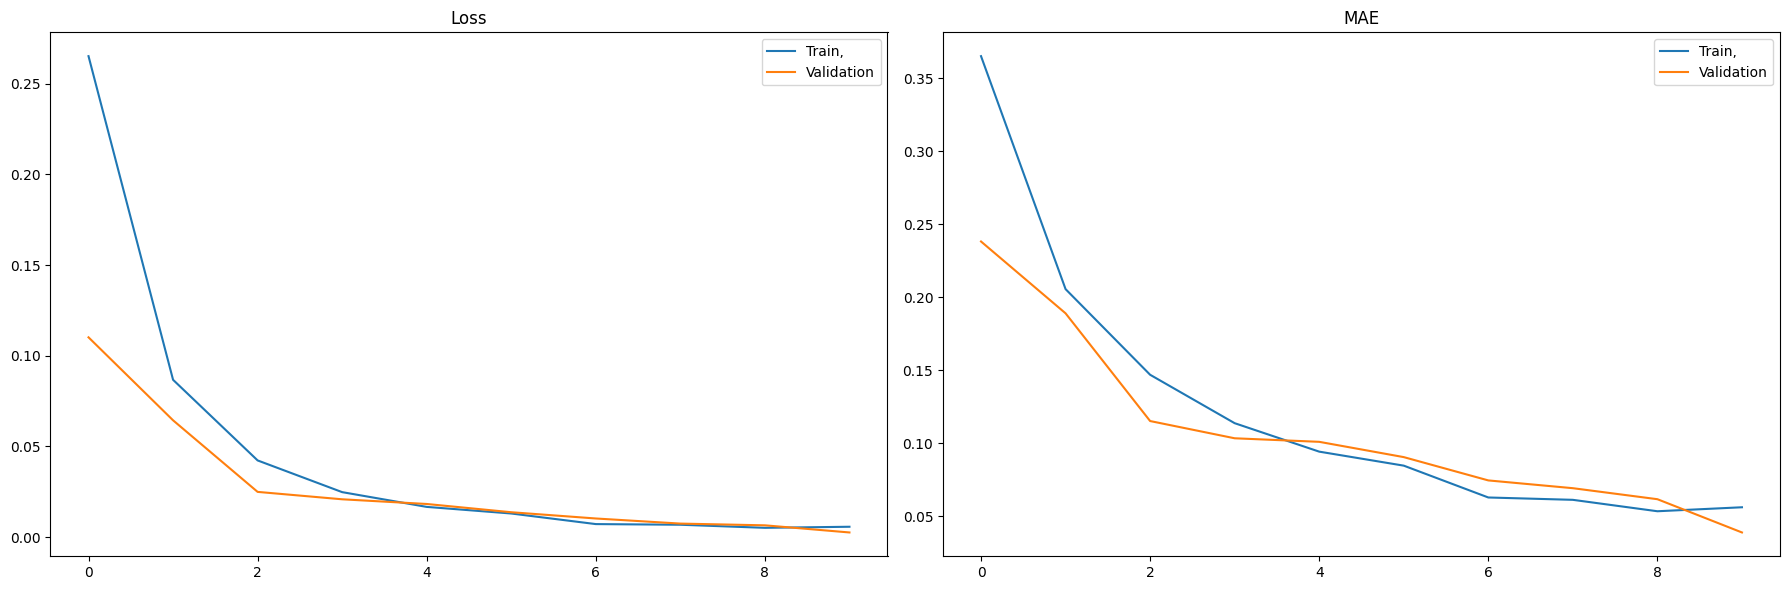

In [7]:
fig, axis = plt.subplots(1, 2, figsize=(18,6))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')


# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.tight_layout()
plt.show()

In [8]:
predictions = yScaler.inverse_transform(model.predict(x_val))

153/153 [==============================] - 2s 13ms/step


In [9]:
def plot_posterior_density(X, ax, title='', color='green',alpha=0.1,linewidth=1):
    sns.kdeplot(X,fill=False, ax=ax, color=color,alpha=alpha,linewidth=linewidth)
    #ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_xlabel('X')
    ax.set_ylabel('Densidad')
    ax.set_title(title)

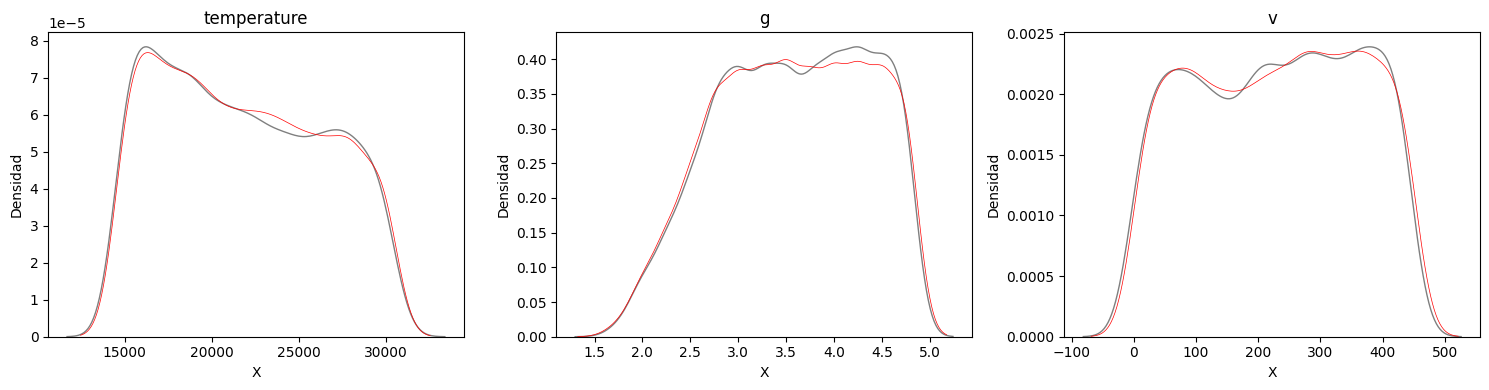

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

original_y_val = yScaler.inverse_transform(y_val)

for i, featureName in enumerate(target):
	plot_posterior_density(predictions[:,i], axes[i], featureName,color = 'black',alpha=0.5)
	plot_posterior_density(original_y_val[:,i], axes[i], featureName, color='red', alpha=1,linewidth=0.5)

plt.tight_layout()
plt.show()

# 4. Ensemble

In [11]:
from keras.optimizers import Adam

NUM_MODELS = 100
models = [generate_model() for i in range(NUM_MODELS)]
history = []


for model in models:
	optimizer = Adam()
	model.compile(loss='MAE',optimizer=optimizer)
	history.append(model.fit(x=x_train, y=y_train, epochs=10))

Epoch 1/10
459/459 [==============================] - 15s 29ms/step - loss: 0.3949
Epoch 2/10
459/459 [==============================] - 13s 29ms/step - loss: 0.2217
Epoch 3/10
459/459 [==============================] - 13s 29ms/step - loss: 0.1638
Epoch 4/10
459/459 [==============================] - 13s 29ms/step - loss: 0.1393
Epoch 5/10
459/459 [==============================] - 13s 29ms/step - loss: 0.1231
Epoch 6/10
459/459 [==============================] - 13s 29ms/step - loss: 0.1022
Epoch 7/10
459/459 [==============================] - 14s 31ms/step - loss: 0.1019
Epoch 8/10
459/459 [==============================] - 14s 30ms/step - loss: 0.0923
Epoch 9/10
459/459 [==============================] - 14s 30ms/step - loss: 0.0799
Epoch 10/10
459/459 [==============================] - 14s 30ms/step - loss: 0.0770
Epoch 1/10
459/459 [==============================] - 16s 31ms/step - loss: 0.3661
Epoch 2/10
459/459 [==============================] - 14s 30ms/step - loss: 0.2114
Epo

In [12]:
predictions = [model.predict(x_test) for model in models] # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 2s 13ms/step


In [13]:
for i,m in enumerate(predictions):
    f = open('./predictions/m_'+str(i)+'.txt','w')
    for row in m:
        for p in row:
            f.write(str(p)+' ')
        f.write('\n')
    f.close()

In [114]:
weights = [model.evaluate(x_val, y_val) for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])


77/77 [==============================] - 1s 14ms/step - loss: 0.1573


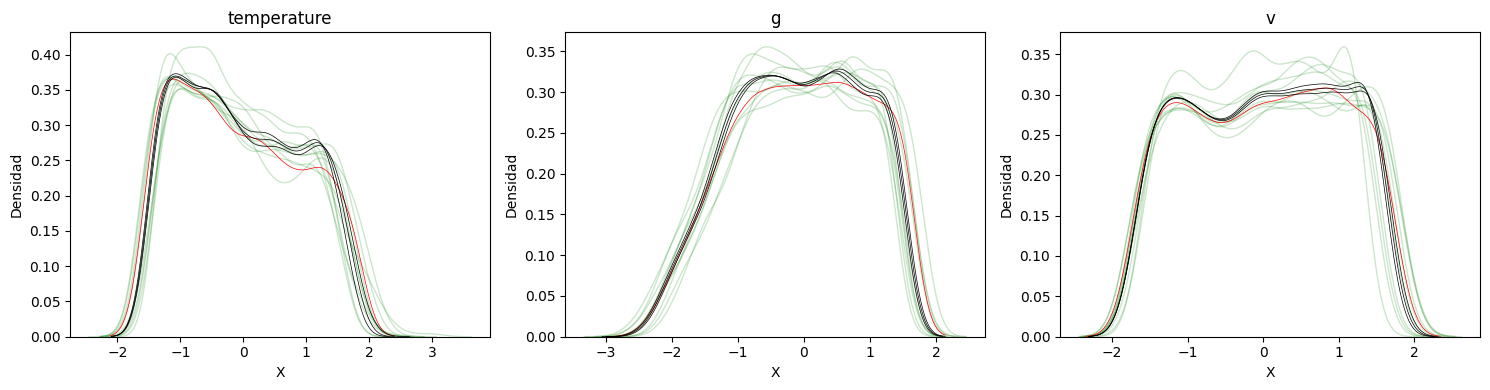

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))


for i, featureName in enumerate(target):
  for j in range(NUM_MODELS):
    plot_posterior_density(predictions[j][:,i], axes[i], featureName,alpha=0.2)
    
  upperBound = ensemble_prediction[:,i] + uncertainty[:,i]
  lowerBound = ensemble_prediction[:,i] - uncertainty[:,i]
  plot_posterior_density(y_val[:,i], axes[i], featureName, color='red', alpha=1,linewidth=0.5)
  plot_posterior_density(ensemble_prediction[:,i], axes[i], featureName, color='black', alpha=1,linewidth=0.5)
  plot_posterior_density(upperBound, axes[i], featureName, color='black', alpha=1,linewidth=0.5)
  plot_posterior_density(lowerBound, axes[i], featureName, color='black', alpha=1,linewidth=0.5)

plt.tight_layout()
plt.show()

# Espectro real

In [116]:
import math
fileName = 'HD60606_2012-11-13_08-02-38_final_corr.txt'
f = open('../Data/RealSpectra/'+fileName)

data = f.readlines()
intensities = []
frequencies = []

for row in data:
	freq, intensity = row.split() 
	if float(freq) >= 4440.0 and float(freq) <= 4510.0:
		frequencies.append(float(freq))
		intensities.append(float(intensity))
    
#print(len(intensities))
f = len(frequencies)/83
for i in range(82,-1,-1):
	intensities.pop(math.floor(i*f))
	frequencies.pop(math.floor(i*f))


TabError: inconsistent use of tabs and spaces in indentation (365685427.py, line 19)

In [ ]:
predictions = [model.predict([intensities]) for model in models]

1/1 [==============================] - 0s 167ms/step


In [ ]:
import numpy as np
real_pred = np.mean(np.array(predictions),axis=0)

ensemble_prediction = sum([real_pred*weights[i] for i in range(len(models))])
uncertainty = sum([(real_pred-ensemble_prediction)**2*weights[i] for i in range(len(models))])


In [ ]:
yScaler.inverse_transform(ensemble_prediction)

array([[3.6007082e+04, 3.4156475e+00, 2.6998047e+01]], dtype=float32)